In [110]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
import sys
import os
from glob import glob

In [3]:
sys.path.append('../../')

In [111]:
from bertrand.training.evaluate import get_epochs_to_step, PeptideTCRDataset, metrics_per_epoch, aggregate_metrics_per_epoch

In [138]:
from bertrand.training.metrics import mean_auroc_per_peptide_cluster_probs
from typing import List, Tuple
import torch
def metrics_per_epoch2(
    pred_list: List[Tuple[np.ndarray, np.ndarray]],
    val_dataset: PeptideTCRDataset,
    subset: str,
    peptide_col: str = "peptide_seq",
) -> pd.DataFrame:
    """
    Computes AUROC for every peptide for every epoch
    :param pred_list: list of predictions for every epoch
    :param val_dataset: dataset to evaluate on
    :param subset: subset of the dataset (can be `val` or `test`)
    :param peptide_col: name of the column for peptide group (can be `peptide_seq` or `peptide_cluster`)
    :return: dataframe of AUROC values of shape (n_epochs, n_peptides)
    """
    rocs_list = []
    n = None
    for i, (predictions, labels) in enumerate(pred_list):
#         print(predictions.shape, labels.shape, (val_dataset.examples.split == subset).shape)
        epoch_results_val = mean_auroc_per_peptide_cluster_probs(
            labels, 
            predictions,
            val_dataset.examples[peptide_col],
            val_dataset.examples.split == subset,
            agg=False,
        )
#         print(epoch_results_val.head())
        epoch_results_val = epoch_results_val[(epoch_results_val.n >= 5) & (epoch_results_val.nn >= 5)]
        n = epoch_results_val.set_index("peptide").n
        epoch_results_val = epoch_results_val.set_index("peptide").rocs
        epoch_results_val.name = i
        rocs_list.append(epoch_results_val)

    results_val = pd.concat(rocs_list, axis=1)
    results_val["n"] = n
    results_val = (
        results_val.reset_index()
        .sort_values(by="n", ascending=False)
        .set_index(["peptide", "n"])
    )
    return results_val

In [180]:
p = [0, 20, 40, 60, 80, 100]

In [181]:
def get_test_metric_per_epoch(model_dir, dataset):
    cv_seed = int(os.path.split(model_dir)[-1].replace("cv_seed=", ""))
    epochs_to_step = get_epochs_to_step(model_dir)

    val_test_dataset = PeptideTCRDataset(dataset, cv_seed, "val+test")
    # cancer_dataset = PeptideTCRDataset(dataset, cv_seed, "cancer")

    pred_fn = os.path.join(model_dir, "predictions.pkl")
    pred_list = pd.read_pickle(pred_fn)

    rocs_val = metrics_per_epoch(pred_list, val_test_dataset, subset="val")
    weighted_average_val, average_val, std_val = aggregate_metrics_per_epoch(rocs_val)
    best_epoch = weighted_average_val.idxmax()
    
    rocs_test = metrics_per_epoch(pred_list, val_test_dataset, subset="test")
    weighted_average_test, average_test, std_test = aggregate_metrics_per_epoch(rocs_test)
    
    results = []
    t1 = 0
    t2 = 100
    results.append({
            "score": average_test.iloc[best_epoch], 
            "t1": t1,
            "t2": t2,
            "percentile": f"0-100",
            
        })
    
    

    ds = val_test_dataset.examples
    avg_dist = ds.loc[ds.y == 0, 'avg_pos_dist']
    
    thresholds = np.percentile(avg_dist, p)
    # avg_dist.hist(bins=20)
    # plt.show()
    
    
    def score_subset(mask1):
        dataset_1 = ds[mask1]
        val_test_dataset.examples = dataset_1.reset_index(drop=True)
        pred_list_1 = []
        for p in pred_list:
            probs = torch.nn.functional.softmax(torch.tensor(p.predictions), 1).numpy()[:, 1]
            pred_list_1.append((probs[mask1], p.label_ids[mask1]))

        rocs_test = metrics_per_epoch2(pred_list_1, val_test_dataset, subset="test")
#         print(rocs_test.head())
#         raise Exception()
        weighted_average_test, average_test, std_test = aggregate_metrics_per_epoch(
            rocs_test
        )
        return average_test.iloc[best_epoch]
    
    
    
    for i in range(len(thresholds)-1):
        t1 = thresholds[i]
        t2 = thresholds[i+1]
#         print(t1, t2)
        mask_neg = (ds.y == 0) & (ds.avg_pos_dist >= t1) & (ds.avg_pos_dist < t2)
#         print(mask_neg.sum())

#         closest_pos_CDR3b = ds.loc[mask_neg, 'closest_pos_CDR3b']
#         mask_pos = (ds.y == 1) & ds.CDR3b.isin(closest_pos_CDR3b)
        mask1 = mask_neg | (ds.y==1)
#         mask2 = mask_neg | mask_pos
#         mask3 = mask_neg | ((ds.y==1) & (~mask_pos))
#         r = {
#             "rocs1": score_subset(mask1),
#             "rocs2": score_subset(mask2),
#             "rocs3": score_subset(mask3),
#         }
        r = {
            "score": score_subset(mask1), 
            "t1": t1,
            "t2": t2,
            "percentile": f"{p[i]}-{p[i+1]}",
            
        }
        results.append(r)
    return pd.DataFrame(results)

In [98]:
bertrand_results_per_epoch = defaultdict(list)

In [99]:
results_dirs = {
#     'baseline': '/mnt/storage2/olek/bertrand-rep3/training-nomlm/',
    'pretrained': '/mnt/storage2/olek/bertrand-rep3/training-dean/'
}

In [100]:
datasets_dir = '../../results/negative_decoys/datasets/'


In [101]:
!ls /mnt/storage2/olek

bertrand-gdrive       bertrand-paper  bertrand-rep2  encodings
bertrand-outputs.zip  bertrand-rep1   bertrand-rep3


In [145]:
results_list = []
for dataset_fn in sorted(glob(os.path.join(datasets_dir, "*.csv.gz"))):
    dataset_name = os.path.basename(dataset_fn).replace(".csv.gz", "")
    dataset = pd.read_csv(dataset_fn, low_memory=False)
    print(dataset_name)
    for model_name, results_dir in results_dirs.items():
        dataset_results_dir = os.path.join(results_dir, dataset_name)
        print(model_name)
        for model_dir in sorted(glob(os.path.join(dataset_results_dir, "cv_seed=*"))):
            print(model_dir)
            cv_seed = int(os.path.split(model_dir)[-1].replace('cv_seed=', ''))
            if cv_seed == 45:
                break
            results = get_test_metric_per_epoch(model_dir, dataset)
            results['dataset'] = dataset_name
            results['cv_seed'] = cv_seed
            results_list.append(results)
#             raise Exception()
        break

dataset_42
pretrained
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_42/cv_seed=42
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_42/cv_seed=43
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_42/cv_seed=44
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_42/cv_seed=45
dataset_43
pretrained
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_43/cv_seed=42
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_43/cv_seed=43
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_43/cv_seed=44
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_43/cv_seed=45
dataset_44
pretrained
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_44/cv_seed=42
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_44/cv_seed=43
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_44/cv_seed=44
/mnt/storage2/olek/bertrand-rep3/training-dean/dataset_44/cv_seed=45


In [146]:
results_df = pd.concat(results_list)

In [148]:
results_df.sample()

,score,t1,t2,percentile,dataset,cv_seed
2,0.593559,8.067278,8.568516,20-40,dataset_42,44


0     0-100
1      0-20
2     20-40
3     40-60
4     60-80
5    80-100
Name: percentile, dtype: object

In [155]:
# results_df

[(0.3254901960784314, 0.6431372549019608, 0.050980392156862744),
 (0.3607843137254902, 0.6149019607843138, 0.1411764705882353),
 (0.39607843137254906, 0.5866666666666667, 0.23137254901960785),
 (0.43137254901960786, 0.5584313725490196, 0.32156862745098036),
 (0.4666666666666667, 0.5301960784313725, 0.411764705882353),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

In [185]:
ax.get_ylim()

(0.0, 0.4455144594483986)

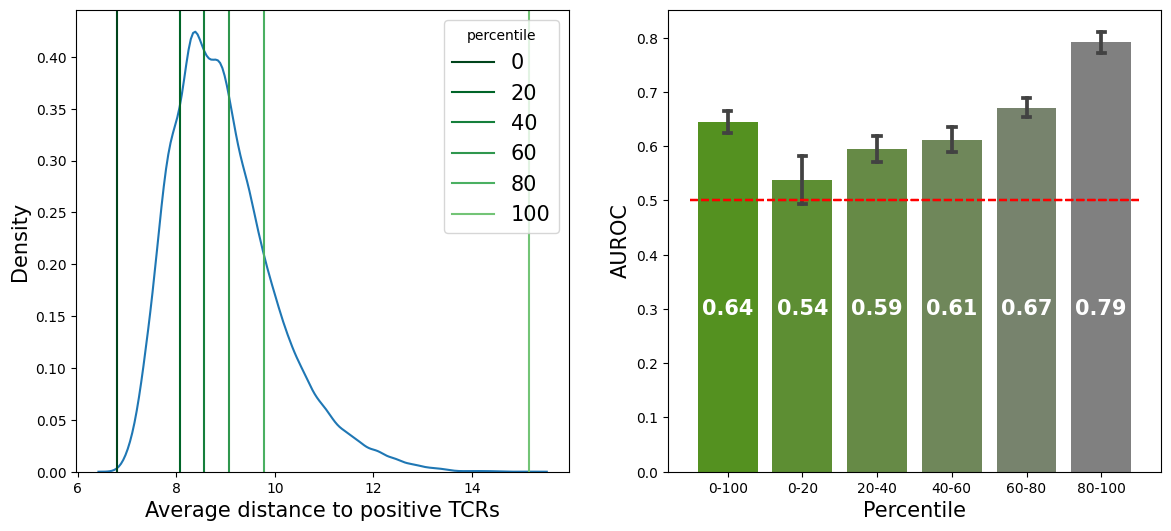

In [217]:
fig, axs = plt.subplots(ncols=2)
ax = axs[0]

sns.kdeplot(avg_dist, ax=axs[0])
for i in range(len(p)):
    t = np.percentile(avg_dist, p[i])
    ymax = ax.get_ylim()[1]
    ax.axvline(t, ymin=0, ymax=1, label=f'{p[i]}', color=plt.get_cmap('Greens')(1-i/10))
ax.legend(title='percentile', loc='upper right', fontsize=15)
ax.set_xlabel('Average distance to positive TCRs', fontsize=15)
ax.set_ylabel('Density', fontsize=15)

ax = axs[1]
data = results_df
x = "percentile"
y = "score"
x_order = list(results_df.percentile.drop_duplicates())

sns.barplot(
    data=data,
    x=x,
    y=y,
    ax=ax,
    capsize=0.1,
    ci="sd",
    order=x_order,
    palette=sns.color_palette("blend:#53A40D,grey")
)
ax.set_xlabel('Percentile', fontsize=15)
ax.set_ylabel('AUROC', fontsize=15)
auroc_mean = data.groupby(x)[y].agg("mean")
auroc_mean = auroc_mean.reindex(x_order)
for i, roc in enumerate(auroc_mean):
    if np.isnan(roc):
        continue
    text = "%.2f" % roc
    ax.text(
            i, 0.3, text, color="white", fontweight="bold", fontsize=15, ha="center", va="center"
        )
    ax.hlines(0.5, -0.5, 5.5, color="red", linestyle="--")

fig.set_size_inches(14, 6)
fig.savefig('/home/ardigen/Desktop/doktorat/thesis/distance_auc.png', dpi=600)
plt.show()